# Fully-Connected Network (TensorFlow)

---

# Log Workflow

In [1]:
import os, sys

import numpy as np

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

from verta import ModelDBClient

## Instantiate Client

In [2]:
client = ModelDBClient()
proj = client.set_project("MNIST Multiclassification")
expt = client.set_experiment("FC-NN")

## Begin Experiment Run

In [3]:
run = client.set_experiment_run("Test Run")

# define everything we need to run this experiment
TRAIN_DATA_PATH = os.path.join("..", "data", "mnist", "train.npz")
TEST_DATA_PATH = os.path.join("..", "data", "mnist", "test.npz")
VAL_PLOT_PATH = os.path.join("..", "output", "val_obs.png")
MODEL_PATH = os.path.join("..", "output", "tensorflow-basic.hdf5")

HIDDEN_SIZE = 512
DROPOUT = 0.2

OPTIMIZER = 'adam'
LOSS = 'sparse_categorical_crossentropy'

BATCH_SIZE = 1024
NUM_EPOCHS = 4
VALIDATION_SPLIT = 0.1

## Define and Log Model

In [4]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(HIDDEN_SIZE, activation=tf.nn.relu))
model.add(keras.layers.Dropout(DROPOUT))
model.add(keras.layers.Dense(10, activation=tf.nn.softmax))

run.log_hyperparameter("hidden size", HIDDEN_SIZE)
run.log_hyperparameter("dropout", DROPOUT)

## Compile and Log Training Procedure

In [5]:
model.compile(optimizer=OPTIMIZER,
              loss=LOSS,
              metrics=['accuracy'])

run.log_hyperparameter("optimizer", OPTIMIZER)
run.log_hyperparameter("loss", LOSS)

## Load and Log Training Data

In [6]:
train_data = np.load(TRAIN_DATA_PATH)
run.log_dataset("train data", TRAIN_DATA_PATH)
run.log_dataset("test data", TEST_DATA_PATH)

X_train, y_train = train_data['X'], train_data['y']

## Run and Log Validation

In [7]:
run.log_hyperparameter("batch size", BATCH_SIZE)
run.log_hyperparameter("num epochs", NUM_EPOCHS)
run.log_hyperparameter("validation split", VALIDATION_SPLIT)

def log_validation(epoch, logs):  # Keras will call this each epoch
    run.log_observation("val train loss", float(logs['loss']))
    run.log_observation("val train acc", float(logs['acc']))
    run.log_observation("val loss", float(logs['val_loss']))
    run.log_observation("val acc", float(logs['val_acc']))

_ = model.fit(X_train, y_train, validation_split=VALIDATION_SPLIT,
              batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
              callbacks=[keras.callbacks.LambdaCallback(on_epoch_end=log_validation)])

Train on 54000 samples, validate on 6000 samples
Epoch 1/4
54000/54000 [==============================] - 3s 64us/step - loss: 0.6297 - acc: 0.8301 - val_loss: 0.2350 - val_acc: 0.9355
Epoch 2/4
54000/54000 [==============================] - 7s 136us/step - loss: 0.2502 - acc: 0.9307 - val_loss: 0.1742 - val_acc: 0.9545
Epoch 3/4
54000/54000 [==============================] - 7s 126us/step - loss: 0.1907 - acc: 0.9468 - val_loss: 0.1409 - val_acc: 0.9633
Epoch 4/4
54000/54000 [==============================] - 7s 123us/step - loss: 0.1526 - acc: 0.9574 - val_loss: 0.1215 - val_acc: 0.9670


## Produce and Log Accuracy Plot

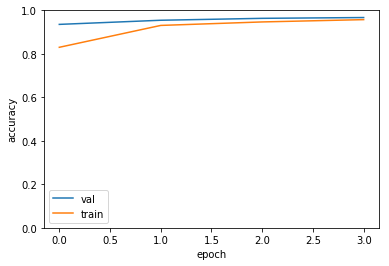

In [8]:
# retrieve observations from our ExperimentRun instance
plt.plot(run.get_observations("val acc"), label="val")
plt.plot(run.get_observations("val train acc"), label="train")

plt.ylim(0, 1)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc='best')

plt.savefig(VAL_PLOT_PATH)
run.log_image("validation plot", VAL_PLOT_PATH)

plt.show()

## Save and Log Model

In [9]:
keras.models.save_model(model, MODEL_PATH)
run.log_model("model", MODEL_PATH)

## Clean Up

In [10]:
client.disconnect()

# delete all variables
%reset -f

---

# Load Workflow

In [11]:
import os, sys

import numpy as np

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

from verta import ModelDBClient

## Instantiate Client

In [12]:
client = ModelDBClient()
proj = client.set_project("MNIST Multiclassification")
expt = client.set_experiment("FC-NN")

## Load Experiment Run

In [13]:
run = client.set_experiment_run("Test Run")

# retrieve everything we need from our ExperimentRun instance
datasets = run.get_datasets()
models = run.get_models()
hyperparameters = run.get_hyperparameters()

TRAIN_DATA_PATH = datasets['train data']
TEST_DATA_PATH = datasets['test data']
VAL_PLOT_PATH = run.get_image("validation plot")
MODEL_PATH = models['model']

HIDDEN_SIZE = hyperparameters['hidden size']
DROPOUT = hyperparameters['dropout']

OPTIMIZER = hyperparameters['optimizer']
LOSS = hyperparameters['loss']

BATCH_SIZE = hyperparameters['batch size']
NUM_EPOCHS = hyperparameters['num epochs']
VALIDATION_SPLIT = hyperparameters['validation split']

## Restore Accuracy Plot

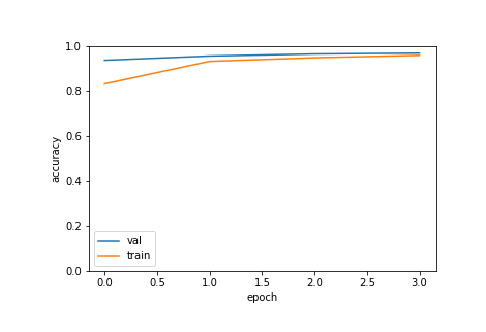

In [14]:
img = plt.imread(VAL_PLOT_PATH)
plt.figure(figsize=(8, 6))
plt.axis('off')

img_plt = plt.imshow(img)

## Restore Model Definition

In [15]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(HIDDEN_SIZE, activation=tf.nn.relu))
model.add(keras.layers.Dropout(DROPOUT))
model.add(keras.layers.Dense(10, activation=tf.nn.softmax))

## Restore Training Procedure Definition

In [16]:
model.compile(optimizer=OPTIMIZER,
              loss=LOSS,
              metrics=['accuracy'])

## Restore Training Data

In [17]:
train_data = np.load(TRAIN_DATA_PATH)
X_train, y_train = train_data['X'], train_data['y']

## Retrain Model on Full Training Set

In [18]:
def log_test(epoch, logs):  # Keras will call this each epoch
    run.log_observation("train loss", float(logs['loss']))
    run.log_observation("train acc", float(logs['acc']))

_ = model.fit(X_train, y_train,
              batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
              callbacks=[keras.callbacks.LambdaCallback(on_epoch_end=log_test)])

Epoch 1/4
60000/60000 [==============================] - 4s 75us/step - loss: 0.5705 - acc: 0.8488
Epoch 2/4
60000/60000 [==============================] - 3s 48us/step - loss: 0.2301 - acc: 0.9361
Epoch 3/4
60000/60000 [==============================] - 3s 53us/step - loss: 0.1732 - acc: 0.9519
Epoch 4/4
60000/60000 [==============================] - 3s 56us/step - loss: 0.1389 - acc: 0.9616


## Run and Log Testing

In [19]:
test_data = np.load(TEST_DATA_PATH)
X_test, y_test = test_data['X'], test_data['y']

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"test_loss: {test_loss:.4f} - test_acc: {test_acc:.4f}")

run.log_metric("test loss", test_loss)
run.log_metric("test acc", test_acc)

10000/10000 [==============================] - 1s 76us/step
test_loss: 0.1325 - test_acc: 0.9612


## Clean Up

In [20]:
client.disconnect()